In [717]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN

## Define model

In [718]:
from pickle import APPEND


class postponed_healthcare_model(BaseModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['W','H','R','NR']
    parameter_names = ['alpha','beta','gamma','epsilon','covid']
    parameters_stratified_names = ['X','I']
    stratification = ['MDC']
    coordinates = [None]
    
    @staticmethod
    def integrate(t, W, H, R, NR, alpha, beta, gamma, epsilon, covid, X, I, MDC):

        dW = 1/alpha*I + (- 1/beta*(X-H) - 1/epsilon*W)*(W>0)
        
        #dW = []
        #for idx, W_i in enumerate(W):
            #if W_i >= 0:
                #dW.append(1/alpha*I[idx] -1/beta*(X[idx]-H[idx]) - 1/epsilon*W_i)
            #else:
                #dW.append(1/alpha*I[idx])
        

        dH = (1/beta*(X-H))*(W>0) - (1/gamma*H)*(H>0)
        dR = (1/gamma*H)*(H>0)
        dNR = (1/epsilon*W)*(W>0)
        
        return dW, dH, dR, dNR   

## Parameters

- *alpha_i = hoeveel dagen wachten mensen om naar het ziekenhuis te gaan*
- *beta_i: = hoeveel dagen duurt het om lege plaatsen in ziekenhuis op te vullen*
- *gamma_i = hoeveel dagen lig je gemiddeld in het ziekenhuis om te recoveren*
- *epsilon_i = Na hoeveel  dagen in de wachtrij verlaten mensen de wachtrij door overlijden, beu zijn...*

In [719]:
# Define MDC classes to model
MDC_dict = {0:'Pre-MDC',1:'Diseases and Disorders of the Nervous System',2:'Diseases and Disorders of the Eye',3:'Diseases and Disorders of the Ear, Nose, Mouth And Throat',4:'Diseases and Disorders of the Respiratory System',5:'Diseases and Disorders of the Circulatory System'}
MDC = np.array([4,5])
# Define model parameters, initial states and coordinates
params={'alpha':1,'beta':1,'gamma':1,'epsilon':1000,'covid':0,'X':np.ones(len(MDC))*100,'I':np.ones(len(MDC))*10,'MDC':MDC}

## Time dependent parameter functions

In [720]:
from covid19model.models.time_dependant_parameter_fncs import make_seasonality_function
amplitudes = [5, 2]
peak_shifts = [0, 5]
mean_illnesses = [10, 15] 
seasonality_function = make_seasonality_function()

def I_func(t, states, param):
    res = []
    for idx,disease in enumerate(MDC):
        res.append(seasonality_function(t, states, param, amplitudes[idx], peak_shifts[idx])+mean_illnesses[idx])
    return np.transpose(res)

In [721]:
start_peak = '2020-02-01'
end_peak = '2020-03-01'
peak_amplitude = 0
params.update({'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude})

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def covid_func(t, states, param,start_peak,end_peak,peak_amplitude):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    # Define policies
    if t <= start_peak:
        return param
    elif start_peak < t <= start_peak+l_days/2:
        return ramp_fun(param, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        return ramp_fun(param, 0, t, start_peak, l/2)
    else:
        return param


In [722]:
X_tot = len(MDC)*params['X']
covid_priority = 1
respi_idx = np.where(MDC==4)[0][0]

params.update({'covid_priority':covid_priority})
def X_func(t, states, param, covid_priority):
    covid = model.parameters['covid']
    X_respi = param[respi_idx] + covid
    param = param - param/(sum(param)-param[respi_idx])
    param[respi_idx] = X_respi
    return param

## Initialize model

In [723]:
init_states = {'H':np.ones(len(MDC))*10}
coordinates=[MDC,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'I': I_func,'covid': covid_func,'X':X_func})

## simulate model

In [724]:
#set start and end date
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-06-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

out = model.sim(sim_len,start_date=start_date,method='')

KeyboardInterrupt: 

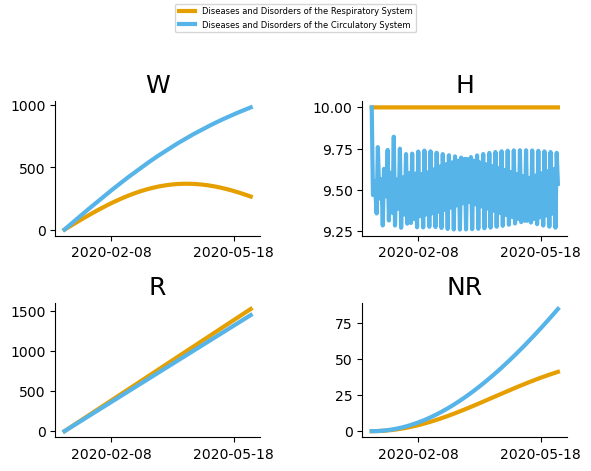

In [ ]:
time = out['time']
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)

for idx, state in enumerate(model.state_names):
    for disease in MDC:
        axs[idx].plot(time,out.sel(MDC=disease)[state], label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=6)
plt.show()